In [1]:
# Importing functions
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px

import scipy.stats as scs
from scipy.stats import t
from scipy.stats import f
from scipy.stats import norm
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols
from Functions import func_rename, func_conversion

from sklearn.linear_model import LinearRegression

sns.set_theme(style="ticks")  # Setting the theme for all plots


I got an email from a client. Swedcar.
The email states that they would like to present a analysis to their customer (Stures bil AB) in order to sell their new fuel efficient motors.

They want me to make the data set more appealing and make it more readable for a European demographic.

The email also mentions Stures Car AB seems a bit stuck in the past so I'll have to make sure to have confident statistics to make Swedcars selling points stronger. 

### First lets start with exploring / cleaning the data

In [2]:
# Importing and cleaning data
filepath = "../Lab/Data/cars.csv"  # Creating filepath
df = pd.read_csv(filepath)  # reading csv with pandas

# Adding columns
df[["name", "test"]] = df["name"].str.split(
    " ", 1, expand=True
)  # Creating a new column
df.rename(
    columns={"name": "make", "test": "model", "mpg": "lper100km"}, inplace=True
)  # Renaming columns
cars = df  # Creating a new dataframe

# Handling spelling mistakes:
#   The spelling mistakes were found by manually looking through the data.
#   func_rename can be found in the Functions.py file
func_rename(cars, "vw", "volkswagen"), func_rename(cars, "vokswagen", "volkswagen")
func_rename(cars, "chevy", "chevrolet"), func_rename(cars, "chevroelt", "chevrolet")
func_rename(cars, "maxda", "mazda"), func_rename(cars, "toyouta", "toyota")
func_rename(cars, "mercedes-benz", "mercedes"),

# Converting the weight and miles per gallon into the metric system.
#  func_conversion can be found in the Functions.py file
func_conversion(cars, "weight")
func_conversion(cars, "lper100km")

# Lets check if any data is missing.
cars.isna().sum()
np.where(cars.isna().any(axis=1))  # Checking for nans.
nanlist = [32, 126, 150, 330, 336, 346, 354, 374]  # The indexes for nan values.
for i in range(len(nanlist)):
    print(cars.iloc[nanlist[i]])  # Simple forloop to print out all nan rows.

# Total NaNs in dataframe is 8. 8/len(cars) ~ 2 %
# I find it acceptable to drop NaNs due to the value being so low. Would it be higher I would have to fill the data with the mean or ask the client for a complete sample

cars.dropna(inplace=True)


lper100km        9.41
cylinders           4
displacement     98.0
horsepower        NaN
weight            928
acceleration     19.0
model_year         71
origin            usa
make             ford
model           pinto
Name: 32, dtype: object
lper100km           11.2
cylinders              6
displacement       200.0
horsepower           NaN
weight              1304
acceleration        17.0
model_year            74
origin               usa
make                ford
model           maverick
Name: 126, dtype: object
lper100km         9.05
cylinders            4
displacement     108.0
horsepower        93.0
weight            1085
acceleration      15.5
model_year          74
origin           japan
make            subaru
model             None
Name: 150, dtype: object
lper100km               5.75
cylinders                  4
displacement            85.0
horsepower               NaN
weight                   832
acceleration            17.3
model_year                80
origin                e

C:\Users\Agam\AppData\Local\Temp\ipykernel_33648\1780337451.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[["name", "test"]] = df["name"].str.split(
c:\Users\Agam\Documents\Programming\Repos\Statistical_Analysis_Alexander_Andersson\Lab\Functions.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column][p] = round(dataframe[column][p]*0.45359237) #Correct math for converting
c:\Users\Agam\Documents\Programming\Repos\Statistical_Analysis_Alexander_Andersson\Lab\Functions.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

Now with the data cleaned and imperial mesuarments converted into metric for a European demographic I'll start exploring the data.

In [3]:
cars.describe()

,lper100km,cylinders,displacement,horsepower,weight,acceleration,model_year
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,11.264231,5.479487,194.883333,104.594872,1352.356410,15.535641,75.971795
std,3.916624,1.706886,104.703657,38.538599,385.463663,2.763569,3.683036
min,5.050000,3.000000,68.000000,46.000000,732.000000,8.000000,70.000000
25%,8.110000,4.000000,105.000000,75.250000,1010.250000,13.725000,73.000000
50%,10.475000,4.000000,151.000000,94.500000,1275.000000,15.500000,76.000000
75%,13.840000,8.000000,293.250000,128.000000,1641.250000,17.000000,79.000000
max,26.140000,8.000000,455.000000,230.000000,2331.000000,24.800000,82.000000


## Auto-mpg dataset statistical analysis

One way that "Swedcar" can prove that their new engines are better is comparing newer car manufacturing to older in order to prove that newer cars and newer motors are more fuel efficient.

In [4]:
# Ill start by splitting the data set. into two parts dependant of the year.
cars["model_year"].unique()
cars_older = cars[
    (cars["model_year"] == 70)
    | (cars["model_year"] == 71)
    | (cars["model_year"] == 72)
    | (cars["model_year"] == 73)
    | (cars["model_year"] == 74)
    | (cars["model_year"] == 75)
]
cars_newer = cars[
    (cars["model_year"] == 76)
    | (cars["model_year"] == 77)
    | (cars["model_year"] == 78)
    | (cars["model_year"] == 79)
    | (cars["model_year"] == 80)
    | (cars["model_year"] == 81)
    | (cars["model_year"] == 82)
]


Ill start by comparing the means, variance and most fuel efficient car between the data sets.

In [5]:
new_car_mean = cars_newer["lper100km"].mean()
old_car_mean = cars_older["lper100km"].mean()
print(
    f"Mean value for liters per 100km.\nOlder cars: {round(old_car_mean, 4)}\nNewer cars: {round(new_car_mean, 4)}"
)
print(
    f"Most fuel efficient value for older cars: {cars_older['lper100km'].min()}\nMost fuel efficient value for newer cars: {cars_newer['lper100km'].min()}"
)
print(
    f"Variance for older: {round(cars_older['lper100km'].var(), 2)}\nVariance for newer: {round(cars_newer['lper100km'].var(), 2)}"
)


Mean value for liters per 100km.
Older cars: 13.2859
Newer cars: 9.5491
Most fuel efficient value for older cars: 6.72
Most fuel efficient value for newer cars: 5.05
Variance for older: 15.74
Variance for newer: 8.63


Across the board wins for newer cars! Perfect, but to make Swedcars job to sell their motors to Stures bil AB a bit easier I will visualise the data.

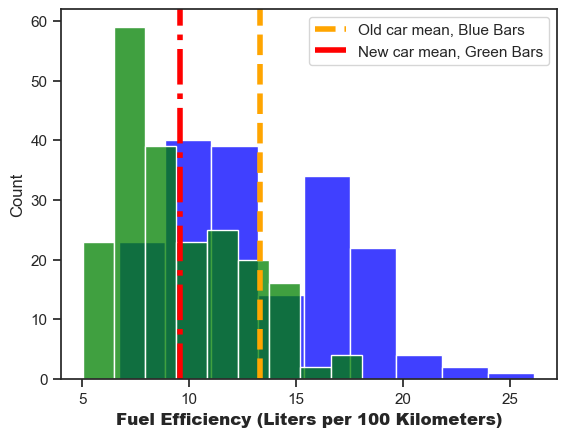

In [14]:
# Lets compare the two data sets in a graph:

ax_1 = sns.histplot(cars_older, x="lper100km", color="blue",).axvline(
    old_car_mean,
    linestyle="--",
    linewidth=4,
    label="Old car mean, Blue Bars",
    color="orange",
)
ax_2 = sns.histplot(cars_newer, x="lper100km", color="green",).axvline(
    new_car_mean,
    linestyle="-.",
    linewidth=4,
    label="New car mean, Green Bars",
    color="red",
)
plt.xlabel("Fuel Efficiency (Liters per 100 Kilometers)", size=12, weight=900)
plt.legend()
plt.savefig("mean_graph")
plt.show()


From what we can see from the above graph newer cars shown in green are more fuel efficient than the older ones shown in blue.
The new mean is also 3.736 units more efficient than the older cars mean.
This is a rather small sample size if we compare it to all cars manufacured during this time.  
So I will calculate the true means by using a 95 % confidence interval.
This will show that the sample mean is true to reality.


In [7]:
alpha = 0.05

# Calculating the true mean.
cars_older_ci = t.interval(
    confidence=1 - alpha,
    df=len(cars_older),
    loc=np.mean(cars_older["lper100km"]),
    scale=scs.sem(cars_older["lper100km"]),
)
cars_newer_ci = t.interval(
    confidence=1 - alpha,
    df=len(cars_newer) - 1,
    loc=np.mean(cars_newer["lper100km"]),
    scale=scs.sem(cars_newer["lper100km"]),
)


print(
    f"Confidence interval with (\u03B1=0.05) fuel consumption {round(cars_older_ci[0],4), round(cars_older_ci[1],4)}\nVariance = {round(cars_older_ci[1] - cars_older_ci[0],4)}\nOlder car mean is inbetween upper and lower values {round(old_car_mean,4)}"
)
print(
    f"\nConfidence interval with (\u03B1=0.05) fuel consumption {round(cars_newer_ci[0],4), round(cars_newer_ci[1],4)}\nVariance = {round(cars_newer_ci[1] - cars_newer_ci[0],4)}\nNewer car mean is inbetween upper and lower values {round(new_car_mean,4)}"
)


Confidence interval with (α=0.05) fuel consumption (12.7008, 13.8711)
Variance = 1.1703
Older car mean is inbetween upper and lower values 13.2859

Confidence interval with (α=0.05) fuel consumption (9.1504, 9.9479)
Variance = 0.7975
Newer car mean is inbetween upper and lower values 9.5491


### So I can be 95% sure that both the older car mean and newer car mean is true to total polulation  
With this information I am able to show that my findings in this data set / sample is applicable in the real world market aswell, So Swedcar is getting a much stronger selling point.  
Let's get back to the combined dataset again and lets see if we can predict how fuel efficient Swedcars new motors will be, based on our limited dataset.

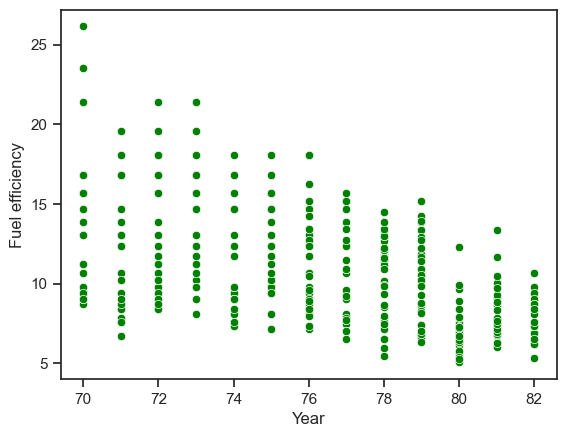

In [8]:
# Ill do a quick scatterplot in order to see if there is any potential in a prediction first
fig = sns.scatterplot(cars, x="model_year", y="lper100km", color="green")
plt.xlabel("Year")
plt.ylabel("Fuel efficiency")
plt.savefig("scatter_graph")
plt.show()


### Looks like we have a clear trend downwards when it comes to fuel efficiency. 

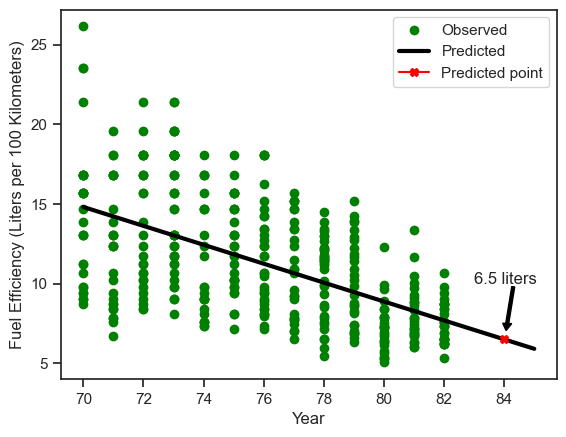

Predicted liters per kilometer for: 
1983: 7.0934
1984: 6.5000
1985: 5.9065

Slope: -0.5934, This is a negative slope, this means that when X (year) increases Y (fuel eff) decreases 
Intercept: 56.3491 is not a valid value for this model due to year not being able to be set at 0   
P-value: 2.6384804542990834e-33 is very low. 268 with 33 zeroes infront. So with (α=0.05) it is very significant.
R: -0.5580 
Standard Error: 0.0448


In [11]:
model = LinearRegression() # Setting the model as Linear Regression
X = cars["model_year"].values.reshape(-1, 1) # Choosing and reshaping model year
y = cars["lper100km"].values # y as efficiency
model.fit(X, y) # Fitting the model

# Fit the linear regression model
slope, intercept, r_value, p_value, std_err = scs.linregress(X.flatten(), y)

# Create a range of future model years
future_model_years = np.arange(
    df["model_year"].min(), df["model_year"].max() + 4, 1
).reshape(-1, 1)

# Predict the lper100km for future years
ypred = slope * future_model_years + intercept # Calculating the future predictions
pred_years = np.array([[83], [84], [85], [95]]) # Setting values for years to predict. 1983, 1984 and so on.
pred_lp100km = model.predict(pred_years) #using model to predict the years.
# Creating a scatter plot with the regression line
plt.scatter(cars["model_year"], y, label="Observed", color="Green")
plt.plot(
    future_model_years,
    ypred,
    color="Black",
    label="Predicted",
    linewidth=3,
)
plt.plot(84, 6.5, marker="X", color="red", label="Predicted point") # plotting a prediction plot.
plt.text(83, 10, "6.5 liters", fontsize=12),    # Prediction value
plt.arrow(84.3, 9.8, -0.2, -2.3, color="black", width = 0.1) # Arrow pointing towards prediction point
plt.xlabel("Year") 
plt.ylabel("Fuel Efficiency (Liters per 100 Kilometers)")
plt.legend()
plt.show()
# Printing out values and predictions.
print(
    f"Predicted liters per kilometer for: \n1983: {pred_lp100km[0]:.4f}\n1984: {pred_lp100km[1]:.4f}\n1985: {pred_lp100km[2]:.4f}"
)
print(
    f"\nSlope: {slope:.4f}, This is a negative slope, this means that when X (year) increases Y (fuel eff) decreases \nIntercept: {intercept:.4f} is not a valid value for this model due to year not being able to be set at 0   \nP-value: {p_value} is very low. 268 with 33 zeroes infront. So with (\u03B1=0.05) it is very significant.\nR: {r_value:.4f} \nStandard Error: {std_err:.4f}"
)
# Intercept is not valuable in this example due to years not being able to be set to 0 Intercept simply anchors the regression line in the right place
# Regression coefieccent is tied to how many "points" will change each aditional year.
# P-value is significant.


We can see a steady decline in liters consumed per 100 kilometers in the years to come.  
A obvious issue with this model is that fuel consumption eventually reach zero and negative values.  
In todays technology that is impossible so we can gather that there must be one or more variables at play when it comes to fuel consumption.
Or if we zoom out from this graph we might be able to see a exponential curve flattening out the further into the future we go.   
With future breakthroughs we might be able to see a sudden drop aswell but that is pure speculation.

In [ ]:
# Proving above point by printing out prediction for 1995
print(f"Predicted liters per kilomiter for: 1995:", round(pred_lp100km[3], 4))


Predicted liters per kilomiter for: 1995: -0.0279


So with that it is inappropriate to use linear regression to predict fuel efficiency soley on years.

But I'm confident that my findings truly show that modern cars are more fuel efficient than older cars.   
Even though there are many variables such as weight, horsepower and cylinders that might play a big part in if a motor is efficient or not.   Swedcar will be able to confidently show Stures bil AB that modern motors are more fuel efficient than the older motors they use now.